## Load mesh

In [5]:
import openmesh as om
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

# mesh = om.read_trimesh('foam15.off')
# mesh = om.read_trimesh('siete_nodos.off')
# mesh = om.read_trimesh('dm4.off')
mesh = om.read_trimesh('T4.off')


## Generate initial setup

In [6]:
V=mesh.points()
def get_T(x,y):
    return x*(1+0.5*(1-y)**2)

def get_S(x,y):
    return x*(1-y)

X=V[:,0]
Y=V[:,1]

T = get_T(V[:,0], V[:,1])
S = get_S(V[:,0], V[:,1])
U = np.array([*T, *S])

In [7]:
## Rutines to calculate gradients


In [9]:
import math

def getGrad2(I, U):
    m = np.zeros((2, 2))
    b = np.zeros((2, 1))

    for k in range(2):
        m[k,0] = V[I[k+1],0]-V[I[0],0]
        m[k,1] = V[I[k+1],1]-V[I[0],1]
        b[k] = U[k+1]-U[0]
                
    g = np.linalg.solve(m, b)    
    
    return g

def getGradients(vh, W):
    nVertex = vh.idx()
    
    vlist = []
    nlist = []    
    
    for vvh in mesh.vv(vh):
        idx = vvh.idx() # devuelve indice del VERTICE
        vlist.append(idx)
        nlist.append(V[nVertex,:]-V[idx,:])
    nlist=np.array(nlist)
    # print(nVertex,': \n', nlist,'\n')
    
    # for n in nlist:
    THETA=[]
    GRADIENT=[]
    for k in range(len(vlist)):
            v1 = nlist[k-1,:]
            v2 = nlist[k,:]
            theta = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
            I=[nVertex, vlist[k-1], vlist[k]]                
                
            if (abs(theta)<math.pi-1e-3) and (abs(theta) > 1e-3) and (abs(theta-math.pi/2)>1e-3):
                g = getGrad2(I, W[I])
                THETA.append(theta)
                GRADIENT.append(g)
                
    THETA=np.array(THETA)  
    GRADIENT=np.array(GRADIENT)

    return THETA, GRADIENT

for vh in mesh.vertices():
    k = vh.idx()
    # if (k>20) and (k < 30):
    #    print(k)
        
    if k > 15:
        break

print(k)

print('nVertex:', vh.idx())
theta, gradient = getGradients(vh, T)

print('\n sum(', theta,') = % .2f' % sum(theta),'\n \n')
print('GRADIENT: \n', gradient.transpose(),'\n \n')

16
nVertex: 16

 sum( [0.3947911  1.37340084 1.37340084 0.3947911  1.37340072 1.37340072] ) =  6.28 
 

GRADIENT: 
 [[[ 1.07499999  1.055       1.035       1.09499999  1.115
    1.135     ]
  [-0.2        -0.29999998 -0.29999998 -0.60000001 -0.49999999
   -0.49999999]]] 
 



...

In [10]:
import math

## Residual
def residual(U):
    N = int(len(U)/2)
    T = U[0:N]
    S = U[N:]
    r = []
    
    for vh in mesh.vertices():
        k = vh.idx()            
            
        # calculate gradients
        theta, gT = getGradients(vh,T)
        theta, gS = getGradients(vh,S)
        # print('gS, gT', theta, gS, gT, '\n ....... \n')
            
        if len(gT) > 0:            
            # calculate the Hamiltonians
            gT_av = gT.transpose().dot(theta)/sum(theta+1e-5)
            gS_av = gS.transpose().dot(theta)/sum(theta+1e-5)            
            
            # residual of T
            rT = np.linalg.norm(gT_av) - V[k,1]/(S[k] + 1e-5)
            rS = gT_av/np.linalg.norm(gT_av+1e-5) - gS_av            
            rS=rS[0] # strange reformatting needed
            
            r.append(rT)
            r.append(rS[0])
            r.append(rS[1])
        # else:
            # print('strange vertex:', k)
            # for vvh in mesh.vv(vh):
            #    print('\t', vvh.idx())       
            
        if V[k,0] == 0:
            r.append(S[k])
            r.append(T[k])
        elif V[k,1] == 1:
            r.append(T[k]-V[k,0])
            r.append(S[k])
            
        #
        #
        # print('k =', k, ', \t r :', r)
        # 
    # print(k)
    r=np.array(r)
    # r=r.transpose()
    
    return r


def cost(u):
    R=residual(u)
    c=np.inner(R,R)
    return c

print('---- > --------------------------------------')
res = residual(U)
print(res.transpose())
print(len(res),'',len(U))
print('------ < ------------------------------------')

---- > --------------------------------------
[ 1.41817695e+00  8.65521249e-02  2.07428076e-02  0.00000000e+00
  0.00000000e+00  1.68196058e+00 -7.01347173e-02  4.61169576e-01
  2.30064706e+00 -2.96675507e-01  1.21213319e+00  3.06587987e+00
 -4.50396556e-01  2.11316286e+00  3.84968124e+00 -5.35408107e-01
  3.01096191e+00 -1.99986744e+04  1.99281572e-01  2.49230242e-02
  0.00000000e+00  0.00000000e+00  1.29776900e+00  5.60702145e-02
  4.83122485e-01  1.95238918e+00 -1.62177977e-01  1.22978996e+00
  2.65810485e+00 -3.16673266e-01  2.12452546e+00  3.36627227e+00
 -4.04825857e-01  3.01851827e+00 -3.99988150e+04  3.99491891e-01
  3.10345481e-02  0.00000000e+00  0.00000000e+00  6.61573055e-01
  2.92159937e-01  5.48266810e-01  1.35313634e+00  1.02651449e-01
  1.28844095e+00  1.93280481e+00 -5.01213814e-02  2.16472141e+00
  2.48972687e+00 -1.42630776e-01  3.04784778e+00 -5.99989171e+04
  5.99726643e-01  3.96745519e-02  0.00000000e+00  0.00000000e+00
 -3.43589248e-01  5.38268294e-01  6.54086512

In [ ]:
# import sys
# 
# print('pipe screen output into file...')
# sys.stdout = open('output.txt', 'w') 

## Run optimization routine

In [ ]:
import scipy.optimize as opt
import time

t0 = time.time()
res = opt.minimize(cost, U, method='powell', tol=1e-10, options={'maxiter': 200, 'disp': True})
t1 = time.time()

print('\n t1-t0: = %.1f' % float(t1 - t0),'\n res:', res)


Take the calculated solution and visualize.


In [15]:
U=res.x

In [16]:
print(U)

[-2.77348184e+00  1.21654869e+00 -3.75078428e+02  1.54665704e+03
  1.23097047e+02 -1.94908738e+04 -2.85363000e+01 -3.33835934e+02
  1.93375593e-01  4.01289062e-03  3.87058653e+00  2.32271986e-03
  2.60961423e+00  3.85511939e-03  4.38183061e-03  4.25253941e-03]


In [18]:

X=V[:,0]
Y=V[:,1]

N = int(len(U)/2)
T = U[0:N]
S = U[N:]

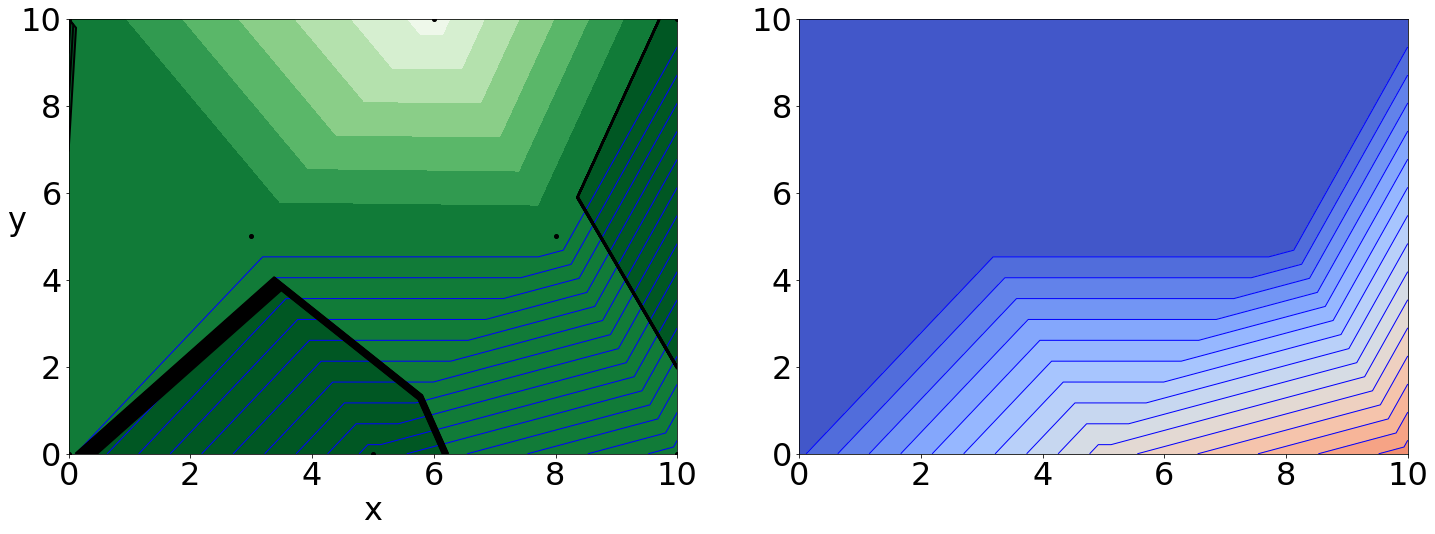

In [19]:
plt.rcParams.update({'font.size': 32})

cmap = plt.get_cmap('Greens')
cmap2=plt.cm.coolwarm
levels1 = np.linspace(0, 9, 21)
levels2 = np.linspace(0, 5, 21)

fig, (plt1, plt2) = plt.subplots(ncols=2, figsize=(24, 8))

plt1.plot(X, Y, '.k', markersize=8)
plt1.tricontourf(X, Y, T, cmap=cmap, zorder=1) # extent=[x0, y0, x1, y1],
plt1.tricontour(X, Y, T, colors='k', linewidths=2, levels=levels1)
plt1.tricontour(X, Y, S, colors='b' , zorder=1, linewidths=1, levels=levels2)

plt1.set_xlabel("x", fontsize=32)
h1=plt1.set_ylabel("y", fontsize=32)
h1.set_rotation(0)
plt.savefig('Tviz')

plt2.tricontourf(X, Y, S, cmap=cmap2 , zorder=1, levels=levels2)
plt2.tricontour(X, Y, S, colors='b' , zorder=1, linewidths=1, levels=levels2)